# Clasificación de imágenes de personas con mascarilla con mejores datos


## 1. Importación de librerías


In [73]:
# General
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2


# Keras
import tensorflow as tf
import keras
from keras.src.utils import image_dataset_from_directory
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Input

from keras.models import Sequential, Model
from keras.utils import to_categorical

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

## 2. Creación de dataframe y partición en train y test


In [74]:
# Parámetros
#IMG_SIZE = (128, 128)
#BATCH_SIZE = 32
#VALIDATION_SPLIT = 0.2

# Cargar el conjunto de entrenamiento
#train_dataset = image_dataset_from_directory(
 #   '/kaggle/input/face-mask/data',
  #  image_size=IMG_SIZE,
   # batch_size=BATCH_SIZE,
   # validation_split=VALIDATION_SPLIT,
    #labels='inferred',
    #label_mode='binary',
    #class_names=['with_mask', 'without_mask'],
    #subset="training",
    #seed=123
#)

# Cargar el conjunto de validación
#val_dataset = image_dataset_from_directory(
  #  '/kaggle/input/face-mask/data',
 #   image_size=IMG_SIZE,
#    batch_size=BATCH_SIZE,
#    validation_split=VALIDATION_SPLIT,
 #   labels='inferred',
  #  label_mode='binary',
   # class_names=['with_mask', 'without_mask'],
   # subset="validation",
   # seed=123
#)

In [75]:
# Cargar todas las imágenes sin dividir
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
data_dir = '/kaggle/input/face-mask/data'
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Convertir el Dataset en un array para poder dividirlo
images = []
labels = []

# Cargar imágenes y etiquetas en listas (2 elementos dada la estructura de datos)
for image_batch, label_batch in full_ds:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

images = np.concatenate(images)
labels = np.concatenate(labels)

# Dividir el conjunto de datos en entrenamiento (80%), validación (10%) y test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

# Volver a convertir a datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

Found 7553 files belonging to 2 classes.


## 3. Normalización de imagenes


In [76]:
#normalization = Rescaling(1./255)
data_augmentation = Sequential([
 RandomFlip("horizontal"), # Volteo horizontal
 RandomRotation(0.2), # Rotaciones 20% de 360º
 RandomZoom(0.1), # Zoom hasta 10%
 RandomTranslation(0.1, 0.1) # Desplaz. vertical y horizontal
])
#train_X = train_dataset.map(lambda x, y:(data_augmentation(normalization(x)), y))
#test_Y = val_dataset.map(lambda x, y: (normalization(x), y))

## 4. Entrenamiento del modelo


In [77]:
early_stopping = EarlyStopping(
 monitor='val_loss', # Métrica a controlar
 min_delta=0.001, # Mejora mínima significativa
 patience=5, # Esperar 10 épocas sin mejora antes de parar
 mode='min', # Monitorizar si la pérdida disminuye
 restore_best_weights=True # Restaurar los mejores pesos
)

model = keras.Sequential([
 Input(shape=(128, 128, 3)),
 data_augmentation,   
 Rescaling(1./255),

 Conv2D(32, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Conv2D(64, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Conv2D(128, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Flatten(),
 Dense(512, activation='relu'),
 Dense(1, activation='sigmoid')  # Solo una neurona para clasificación binaria
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_16 (Sequential)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_8 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
epochs = 30
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7467 - loss: 0.5416 - val_accuracy: 0.8848 - val_loss: 0.2941
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8542 - loss: 0.3436 - val_accuracy: 0.8570 - val_loss: 0.3347
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8673 - loss: 0.3195 - val_accuracy: 0.8371 - val_loss: 0.3482
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8676 - loss: 0.3089 - val_accuracy: 0.8781 - val_loss: 0.2829
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8748 - loss: 0.2949 - val_accuracy: 0.9179 - val_loss: 0.2404
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8825 - loss: 0.2746 - val_accuracy: 0.9166 - val_loss: 0.2359
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8825 - loss: 0.2812 - val_accuracy: 0.9166 - val_loss: 0.2188
Epoch 8/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8974 - loss: 0.2510 - val_accu

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9476 - loss: 0.1599
Pérdida en test: 0.1294
Precisión en test: 0.9536


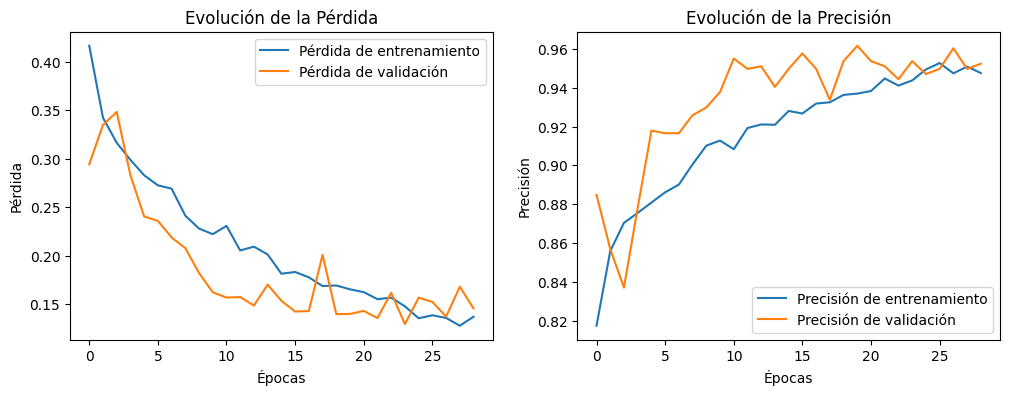

In [79]:
# Evaluación del modelo en el conjunto de test
loss, accuracy = model.evaluate(val_dataset)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")
# Visualización de la evolución del entrenamiento
# Extraer los valores del historial
epochs_range = range(len(history.history['loss']))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')
plt.show()


In [80]:
# Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(val_dataset)

# Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

# Verificar las formas
# print(f"test_Y shape: {test_dataset.shape}")  # Usar labels en test_dataset
print(f"predicted_classes shape: {predicted_classes.shape}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
predicted_classes shape: (755,)


In [81]:
target_names = ["with_mask", "without_mask"]

# Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(val_dataset)

# Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

# Obtener las etiquetas reales
true_labels = []
for _, labels in val_dataset:
    true_labels.append(labels)
true_labels = np.concatenate(true_labels)  # Convertir a array de NumPy

# Verificar las formas
print(f"true_labels shape: {true_labels.shape}")
print(f"predicted_classes shape: {predicted_classes.shape}")

# Mostrar el classification_report
print(classification_report(true_labels, predicted_classes, target_names=target_names))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
true_labels shape: (755, 1)
predicted_classes shape: (755,)
              precision    recall  f1-score   support

   with_mask       0.97      0.94      0.95       384
without_mask       0.94      0.96      0.95       371

    accuracy                           0.95       755
   macro avg       0.95      0.95      0.95       755
weighted avg       0.95      0.95      0.95       755



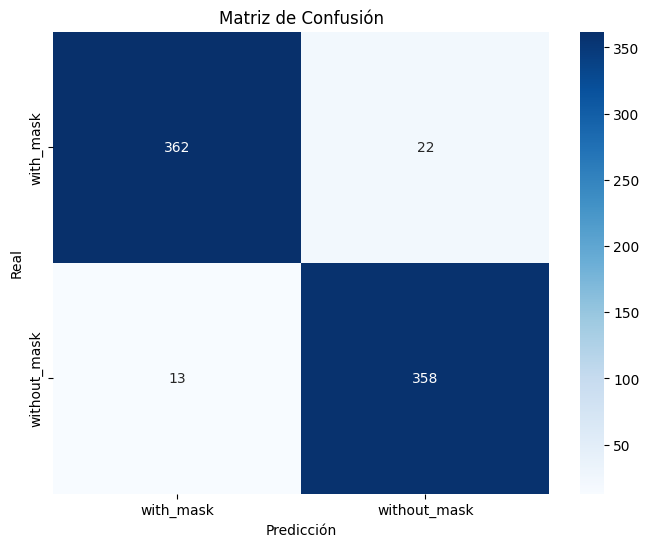

In [82]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Etiquetas correctas para las 10 clases
target_names = ["with_mask", "without_mask"]

# Mostrar matriz de confusión con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()